<a href="https://colab.research.google.com/github/Samir-Doghmi/Deep_Learning/blob/main/1_CNN_on_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras import preprocessing
from keras.layers import Normalization
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
from pathlib import Path
import PIL
from PIL import Image
import statistics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# seed initialization to get same results
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Upload

In [ ]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import file in the virtual machine
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/gdrive/MyDrive/Project_DeepLearning/flower_photos_divided.zip', 'flower_photos_divided.zip') # fonte e dove copiarlo
# Extract files
zip = zipfile.ZipFile('flower_photos_divided.zip') #scompatta cartella zippata
zip.extractall() #invochiamo zip
zip.close() # necessario per accellerare le operazioni
print("File transfer completed in %0.3f seconds" % (time() - t0))

base_path = Path('flower_photos_divided/')

File transfer completed in 8.554 seconds


# Data



## Find the optimal image size

In [ ]:
# each * represents an argument: directory, subdirectory and file name
image_files = list(base_path.glob('*/*/*.jpg'))
widths = []
heights = []
aspect_ratios = []

for image_file in image_files:
    image = Image.open(image_file)
    width, height = image.size
    aspect_ratio = width / height
    widths.append(width)
    heights.append(height)
    aspect_ratios.append(aspect_ratio)
   # print(f"Image: {os.path.basename(image_file)}, Size: {width}x{height},Aspect Ratio: {aspect_ratio:.2f}")

In [ ]:
# we find the most representative measures
mode_width = statistics.median(widths)
mode_height = statistics.median(heights)
mode_aspect_ratios = statistics.median(aspect_ratios)

print("Most representative size:")
print(f"Width: {mode_width}")
print(f"Height: {mode_height}")
print(f"Aspect_ratio: {mode_aspect_ratios}")

Most representative size:
Width: 320.0
Height: 240.0
Aspect_ratio: 1.3445378151260505


## Train and Validation

In [ ]:
# train dataset
train_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/train", #assegniamo a variabile train dataset
                                                            image_size=(240,320), #dimesione standard   # ridimensionate alla stessa dimensione (stessa risoluzione). Per poter sfruttare il batch processing, le immagini vengono impilate in un unico tensore poiche alcuni livelli neurali funzionano in base ad una specifica cardinalità
                                                            batch_size=128,   # 128 immagini di input alla volta. più immagini, più l'apprendimento è stabile
                                                            label_mode='categorical',
                                                            #subset='training',
                                                            #validation_split = 0.2,
                                                            shuffle=True,# Data shuffling (randomization of the instances order) is fundamental to ensure that each minibatch is representative of the whole set of classes
                                                            seed=1)
# 800 file (80%) verrano utilizzati per l'addestramento, mentre 200 per il validation

Found 2935 files belonging to 5 classes.


In [ ]:
# validation dataset
val_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/test", #assegniamo a variabile train dataset
                                                            image_size=(240,320), #dimesione standard   # ridimensionate alla stessa dimensione (stessa risoluzione). Per poter sfruttare il batch processing, le immagini vengono impilate in un unico tensore poiche alcuni livelli neurali funzionano in base ad una specifica cardinalità
                                                            batch_size=128,   # 128 immagini di input alla volta. più immagini, più l'apprendimento è stabile
                                                            label_mode='categorical',
                                                            #subset='validation',
                                                            #validation_split = 0.2,
                                                            shuffle=False,
                                                            seed=1)
# 800 file (80%) verrano utilizzati per l'addestramento, mentre 200 per il validation

Found 735 files belonging to 5 classes.


### Visualize the data

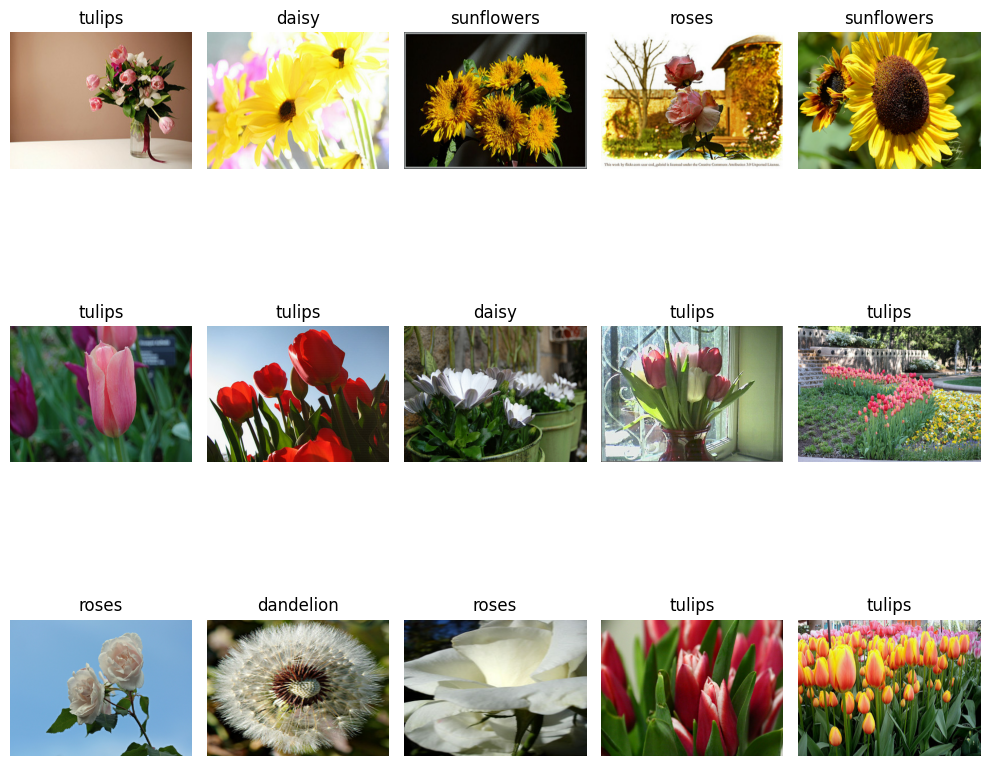

In [ ]:
plt.figure(figsize=(10, 10))
label_names = train_dataset.class_names  # Get the label names from the dataset

for i, (images, labels) in enumerate(train_dataset.unbatch().take(15)):
# unbatch() to get individual images and labels
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
#he images tensor is converted to a NumPy array and cast to an unsigned 8-bit integer data type
    plt.title(label_names[labels.numpy().argmax()]) #si identifca la label più probabile alla quale l'immagine è associata. argmax() opera solo on NumPy arrays
#The labels tensor is converted to a NumPy array, and argmax() is used to find the index of the highest value
    plt.axis("off")

plt.tight_layout() #This line adjusts the spacing between subplots to improve readability.
plt.show()

## Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.4),
     layers.RandomBrightness(factor= 0.4), # allowing the generator to randomly darken the image of 0.2 or 20%
     layers.RandomZoom(0.2),
     layers.RandomCrop(180,260),
     layers.Resizing(224,224),
     layers.Normalization()
    ]
)

### How Data Augmentation works

(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)
(128, 224, 224, 3)


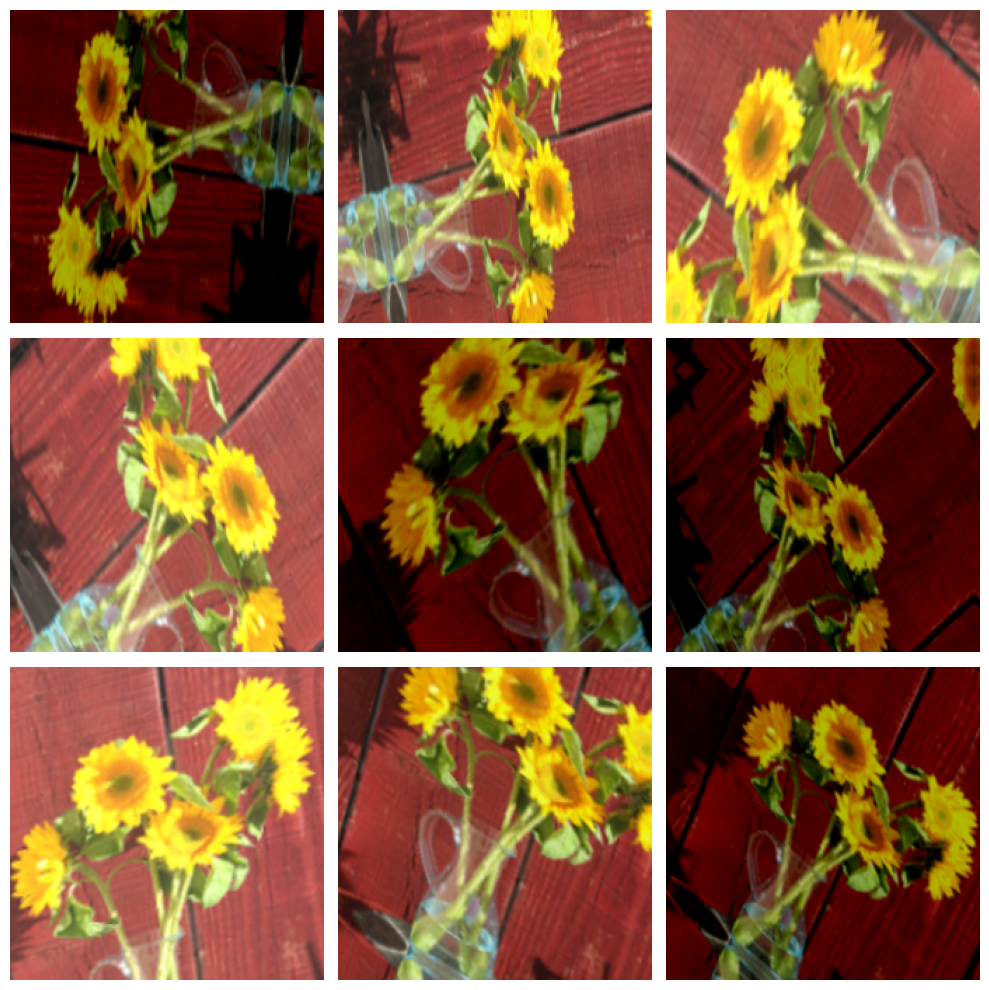

In [ ]:
#Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

plt.figure(figsize=(10, 10))
for images, _ in (train_dataset.take(1)): #The underscore _ is used as a placeholder variable to ignore the labels.
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    print(augmented_images.shape)

plt.tight_layout()
plt.show()



Note that data augmentation is inactive at test time, so the input samples will only be augmented during fit(), not when calling evaluate() or predict().

# Model (custom)



## Definition

In [ ]:
num_classes = 5

In [ ]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)

#we save only the best model
checkpoint_filepath = 'gdrive/MyDrive/Project_DeepLearning/1_CNN_on_scratch'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')



In [ ]:
# Architecture definition
inputs = keras.Input((240,320,3))

#apply a data augmentation
x = data_augmentation(inputs)

x = keras.layers.Conv2D(32, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x) #senza la normalizzazione era lentissimo
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)    #aggiunto nella v2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(256, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)    #aggiunto nella v2
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# dropout hast to be placed after globalmaxpooling
#x = layers.Dropout(0.2) (x)
#x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x = layers.Dropout(0.2) (x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net = keras.Model(inputs, outputs)

In [ ]:
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 sequential_19 (Sequential)  (None, 224, 224, 3)       7         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                       

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.SGD(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Model training
history = net.fit(train_dataset,
          epochs=80,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save]);


Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 2.2075 - accuracy: 0.2664

23/23 [==============================] - 25s 878ms/step - loss: 2.2075 - accuracy: 0.2664 - val_loss: 2.1416 - val_accuracy: 0.2095
Epoch 2/80
23/23 [==============================] - ETA: 0s - loss: 1.8504 - accuracy: 0.3591

23/23 [==============================] - 20s 812ms/step - loss: 1.8504 - accuracy: 0.3591 - val_loss: 2.0212 - val_accuracy: 0.2449
Epoch 3/80
23/23 [==============================] - ETA: 0s - loss: 1.7530 - accuracy: 0.4239

23/23 [==============================] - 22s 870ms/step - loss: 1.7530 - accuracy: 0.4239 - val_loss: 1.9427 - val_accuracy: 0.2993
Epoch 4/80
23/23 [==============================] - ETA: 0s - loss: 1.6718 - accuracy: 0.4651

23/23 [==============================] - 20s 819ms/step - loss: 1.6718 - accuracy: 0.4651 - val_loss: 1.8726 - val_accuracy: 0.3361
Epoch 5/80
23/23 [==============================] - ETA: 0s - loss: 1.6178 - accuracy: 0.4838

23/23 [==============================] - 21s 860ms/step - loss: 1.6178 - accuracy: 0.4838 - val_loss: 1.7763 - val_accuracy: 0.4082
Epoch 6/80
23/23 [==============================] - ETA: 0s - loss: 1.5706 - accuracy: 0.4988

23/23 [==============================] - 20s 815ms/step - loss: 1.5706 - accuracy: 0.4988 - val_loss: 1.7025 - val_accuracy: 0.4395
Epoch 7/80
23/23 [==============================] - ETA: 0s - loss: 1.5400 - accuracy: 0.5043

23/23 [==============================] - 25s 980ms/step - loss: 1.5400 - accuracy: 0.5043 - val_loss: 1.6315 - val_accuracy: 0.4707
Epoch 8/80
23/23 [==============================] - ETA: 0s - loss: 1.4962 - accuracy: 0.5356

23/23 [==============================] - 21s 859ms/step - loss: 1.4962 - accuracy: 0.5356 - val_loss: 1.5830 - val_accuracy: 0.4803
Epoch 9/80
23/23 [==============================] - ETA: 0s - loss: 1.4928 - accuracy: 0.5288

23/23 [==============================] - 20s 814ms/step - loss: 1.4928 - accuracy: 0.5288 - val_loss: 1.5480 - val_accuracy: 0.5088
Epoch 10/80
23/23 [==============================] - ETA: 0s - loss: 1.4547 - accuracy: 0.5489

23/23 [==============================] - 21s 863ms/step - loss: 1.4547 - accuracy: 0.5489 - val_loss: 1.5080 - val_accuracy: 0.5279
Epoch 11/80
23/23 [==============================] - ETA: 0s - loss: 1.4409 - accuracy: 0.5543

23/23 [==============================] - 20s 818ms/step - loss: 1.4409 - accuracy: 0.5543 - val_loss: 1.4857 - val_accuracy: 0.5333
Epoch 12/80
23/23 [==============================] - ETA: 0s - loss: 1.4504 - accuracy: 0.5503

23/23 [==============================] - 22s 858ms/step - loss: 1.4504 - accuracy: 0.5503 - val_loss: 1.4572 - val_accuracy: 0.5265
Epoch 13/80
23/23 [==============================] - ETA: 0s - loss: 1.4289 - accuracy: 0.5676

23/23 [==============================] - 23s 847ms/step - loss: 1.4289 - accuracy: 0.5676 - val_loss: 1.4375 - val_accuracy: 0.5401
Epoch 14/80
23/23 [==============================] - ETA: 0s - loss: 1.4161 - accuracy: 0.5710

23/23 [==============================] - 20s 815ms/step - loss: 1.4161 - accuracy: 0.5710 - val_loss: 1.4330 - val_accuracy: 0.5388
Epoch 15/80
23/23 [==============================] - 16s 617ms/step - loss: 1.4138 - accuracy: 0.5697 - val_loss: 1.4387 - val_accuracy: 0.5306
Epoch 16/80
23/23 [==============================] - ETA: 0s - loss: 1.3961 - accuracy: 0.5792

23/23 [==============================] - 22s 864ms/step - loss: 1.3961 - accuracy: 0.5792 - val_loss: 1.3993 - val_accuracy: 0.5592
Epoch 17/80
23/23 [==============================] - ETA: 0s - loss: 1.3876 - accuracy: 0.5823

23/23 [==============================] - 22s 838ms/step - loss: 1.3876 - accuracy: 0.5823 - val_loss: 1.3957 - val_accuracy: 0.5551
Epoch 18/80
23/23 [==============================] - 16s 610ms/step - loss: 1.3937 - accuracy: 0.5799 - val_loss: 1.3977 - val_accuracy: 0.5537
Epoch 19/80
23/23 [==============================] - ETA: 0s - loss: 1.3884 - accuracy: 0.5779

23/23 [==============================] - 21s 862ms/step - loss: 1.3884 - accuracy: 0.5779 - val_loss: 1.3721 - val_accuracy: 0.5850
Epoch 20/80
23/23 [==============================] - ETA: 0s - loss: 1.3656 - accuracy: 0.5983

23/23 [==============================] - 23s 862ms/step - loss: 1.3656 - accuracy: 0.5983 - val_loss: 1.3640 - val_accuracy: 0.5769
Epoch 21/80
23/23 [==============================] - 16s 606ms/step - loss: 1.3595 - accuracy: 0.5993 - val_loss: 1.3656 - val_accuracy: 0.5796
Epoch 22/80
23/23 [==============================] - ETA: 0s - loss: 1.3645 - accuracy: 0.5997

23/23 [==============================] - 22s 884ms/step - loss: 1.3645 - accuracy: 0.5997 - val_loss: 1.3471 - val_accuracy: 0.5973
Epoch 23/80
23/23 [==============================] - 15s 589ms/step - loss: 1.3500 - accuracy: 0.6116 - val_loss: 1.3537 - val_accuracy: 0.5823
Epoch 24/80
23/23 [==============================] - ETA: 0s - loss: 1.3517 - accuracy: 0.6007

23/23 [==============================] - 20s 791ms/step - loss: 1.3517 - accuracy: 0.6007 - val_loss: 1.3460 - val_accuracy: 0.5932
Epoch 25/80
23/23 [==============================] - ETA: 0s - loss: 1.3405 - accuracy: 0.6153

23/23 [==============================] - 23s 862ms/step - loss: 1.3405 - accuracy: 0.6153 - val_loss: 1.3300 - val_accuracy: 0.6082
Epoch 26/80
23/23 [==============================] - 16s 602ms/step - loss: 1.3291 - accuracy: 0.6126 - val_loss: 1.3339 - val_accuracy: 0.5973
Epoch 27/80
23/23 [==============================] - ETA: 0s - loss: 1.3157 - accuracy: 0.6235

23/23 [==============================] - 21s 818ms/step - loss: 1.3157 - accuracy: 0.6235 - val_loss: 1.3177 - val_accuracy: 0.6000
Epoch 28/80
23/23 [==============================] - 16s 615ms/step - loss: 1.3195 - accuracy: 0.6153 - val_loss: 1.3281 - val_accuracy: 0.5932
Epoch 29/80
23/23 [==============================] - ETA: 0s - loss: 1.3126 - accuracy: 0.6279

23/23 [==============================] - 24s 946ms/step - loss: 1.3126 - accuracy: 0.6279 - val_loss: 1.3145 - val_accuracy: 0.6082
Epoch 30/80
23/23 [==============================] - ETA: 0s - loss: 1.3196 - accuracy: 0.6252

23/23 [==============================] - 22s 876ms/step - loss: 1.3196 - accuracy: 0.6252 - val_loss: 1.3033 - val_accuracy: 0.6150
Epoch 31/80
23/23 [==============================] - ETA: 0s - loss: 1.2937 - accuracy: 0.6368

23/23 [==============================] - 21s 855ms/step - loss: 1.2937 - accuracy: 0.6368 - val_loss: 1.2954 - val_accuracy: 0.6136
Epoch 32/80
23/23 [==============================] - 16s 601ms/step - loss: 1.2942 - accuracy: 0.6296 - val_loss: 1.3008 - val_accuracy: 0.6014
Epoch 33/80
23/23 [==============================] - ETA: 0s - loss: 1.2975 - accuracy: 0.6290

23/23 [==============================] - 21s 842ms/step - loss: 1.2975 - accuracy: 0.6290 - val_loss: 1.2803 - val_accuracy: 0.6150
Epoch 34/80
23/23 [==============================] - ETA: 0s - loss: 1.2972 - accuracy: 0.6317

23/23 [==============================] - 22s 827ms/step - loss: 1.2972 - accuracy: 0.6317 - val_loss: 1.2774 - val_accuracy: 0.6259
Epoch 35/80
23/23 [==============================] - 16s 604ms/step - loss: 1.2812 - accuracy: 0.6293 - val_loss: 1.2801 - val_accuracy: 0.6150
Epoch 36/80
23/23 [==============================] - ETA: 0s - loss: 1.2890 - accuracy: 0.6341

23/23 [==============================] - 21s 861ms/step - loss: 1.2890 - accuracy: 0.6341 - val_loss: 1.2687 - val_accuracy: 0.6218
Epoch 37/80
23/23 [==============================] - ETA: 0s - loss: 1.2637 - accuracy: 0.6460

23/23 [==============================] - 23s 888ms/step - loss: 1.2637 - accuracy: 0.6460 - val_loss: 1.2651 - val_accuracy: 0.6245
Epoch 38/80
23/23 [==============================] - 16s 607ms/step - loss: 1.2688 - accuracy: 0.6395 - val_loss: 1.2654 - val_accuracy: 0.6327
Epoch 39/80
23/23 [==============================] - 16s 608ms/step - loss: 1.2532 - accuracy: 0.6504 - val_loss: 1.2660 - val_accuracy: 0.6313
Epoch 40/80
23/23 [==============================] - 16s 629ms/step - loss: 1.2687 - accuracy: 0.6392 - val_loss: 1.3013 - val_accuracy: 0.6082
Epoch 41/80
23/23 [==============================] - ETA: 0s - loss: 1.2516 - accuracy: 0.6521

23/23 [==============================] - 22s 818ms/step - loss: 1.2516 - accuracy: 0.6521 - val_loss: 1.2531 - val_accuracy: 0.6272
Epoch 42/80
23/23 [==============================] - ETA: 0s - loss: 1.2500 - accuracy: 0.6664

23/23 [==============================] - 21s 859ms/step - loss: 1.2500 - accuracy: 0.6664 - val_loss: 1.2454 - val_accuracy: 0.6544
Epoch 43/80
23/23 [==============================] - 16s 618ms/step - loss: 1.2509 - accuracy: 0.6525 - val_loss: 1.2538 - val_accuracy: 0.6340
Epoch 44/80
23/23 [==============================] - 18s 662ms/step - loss: 1.2453 - accuracy: 0.6589 - val_loss: 1.2607 - val_accuracy: 0.6340
Epoch 45/80
23/23 [==============================] - ETA: 0s - loss: 1.2371 - accuracy: 0.6532

23/23 [==============================] - 20s 813ms/step - loss: 1.2371 - accuracy: 0.6532 - val_loss: 1.2422 - val_accuracy: 0.6517
Epoch 46/80
23/23 [==============================] - ETA: 0s - loss: 1.2443 - accuracy: 0.6508

23/23 [==============================] - 21s 853ms/step - loss: 1.2443 - accuracy: 0.6508 - val_loss: 1.2414 - val_accuracy: 0.6422
Epoch 47/80
23/23 [==============================] - ETA: 0s - loss: 1.2330 - accuracy: 0.6596

23/23 [==============================] - 20s 816ms/step - loss: 1.2330 - accuracy: 0.6596 - val_loss: 1.2333 - val_accuracy: 0.6503
Epoch 48/80
23/23 [==============================] - ETA: 0s - loss: 1.2236 - accuracy: 0.6627

23/23 [==============================] - 22s 872ms/step - loss: 1.2236 - accuracy: 0.6627 - val_loss: 1.2328 - val_accuracy: 0.6435
Epoch 49/80
23/23 [==============================] - ETA: 0s - loss: 1.2202 - accuracy: 0.6705

23/23 [==============================] - 20s 822ms/step - loss: 1.2202 - accuracy: 0.6705 - val_loss: 1.2299 - val_accuracy: 0.6517
Epoch 50/80
23/23 [==============================] - ETA: 0s - loss: 1.2304 - accuracy: 0.6606

23/23 [==============================] - 23s 855ms/step - loss: 1.2304 - accuracy: 0.6606 - val_loss: 1.2235 - val_accuracy: 0.6544
Epoch 51/80
23/23 [==============================] - 16s 604ms/step - loss: 1.2138 - accuracy: 0.6688 - val_loss: 1.2387 - val_accuracy: 0.6449
Epoch 52/80
23/23 [==============================] - ETA: 0s - loss: 1.2246 - accuracy: 0.6596

23/23 [==============================] - 21s 869ms/step - loss: 1.2246 - accuracy: 0.6596 - val_loss: 1.2225 - val_accuracy: 0.6422
Epoch 53/80
23/23 [==============================] - 17s 641ms/step - loss: 1.2157 - accuracy: 0.6600 - val_loss: 1.2225 - val_accuracy: 0.6531
Epoch 54/80
23/23 [==============================] - ETA: 0s - loss: 1.2135 - accuracy: 0.6654

23/23 [==============================] - 21s 828ms/step - loss: 1.2135 - accuracy: 0.6654 - val_loss: 1.2077 - val_accuracy: 0.6544
Epoch 55/80
23/23 [==============================] - 16s 605ms/step - loss: 1.2130 - accuracy: 0.6610 - val_loss: 1.2351 - val_accuracy: 0.6381
Epoch 56/80
23/23 [==============================] - ETA: 0s - loss: 1.1977 - accuracy: 0.6712

23/23 [==============================] - 20s 819ms/step - loss: 1.1977 - accuracy: 0.6712 - val_loss: 1.2041 - val_accuracy: 0.6585
Epoch 57/80
23/23 [==============================] - 16s 612ms/step - loss: 1.2036 - accuracy: 0.6733 - val_loss: 1.2108 - val_accuracy: 0.6599
Epoch 58/80
23/23 [==============================] - ETA: 0s - loss: 1.1988 - accuracy: 0.6719

23/23 [==============================] - 24s 954ms/step - loss: 1.1988 - accuracy: 0.6719 - val_loss: 1.2028 - val_accuracy: 0.6585
Epoch 59/80
23/23 [==============================] - 16s 603ms/step - loss: 1.2071 - accuracy: 0.6617 - val_loss: 1.2062 - val_accuracy: 0.6639
Epoch 60/80
23/23 [==============================] - ETA: 0s - loss: 1.1948 - accuracy: 0.6756

23/23 [==============================] - 20s 814ms/step - loss: 1.1948 - accuracy: 0.6756 - val_loss: 1.2024 - val_accuracy: 0.6667
Epoch 61/80
23/23 [==============================] - 16s 613ms/step - loss: 1.2012 - accuracy: 0.6606 - val_loss: 1.2025 - val_accuracy: 0.6612
Epoch 62/80
23/23 [==============================] - 18s 638ms/step - loss: 1.1837 - accuracy: 0.6739 - val_loss: 1.2060 - val_accuracy: 0.6571
Epoch 63/80
23/23 [==============================] - ETA: 0s - loss: 1.1883 - accuracy: 0.6600

23/23 [==============================] - 20s 793ms/step - loss: 1.1883 - accuracy: 0.6600 - val_loss: 1.1963 - val_accuracy: 0.6680
Epoch 64/80
23/23 [==============================] - 16s 606ms/step - loss: 1.1900 - accuracy: 0.6750 - val_loss: 1.2086 - val_accuracy: 0.6612
Epoch 65/80
23/23 [==============================] - 17s 647ms/step - loss: 1.1924 - accuracy: 0.6685 - val_loss: 1.2026 - val_accuracy: 0.6667
Epoch 66/80
23/23 [==============================] - ETA: 0s - loss: 1.1769 - accuracy: 0.6842

23/23 [==============================] - 21s 830ms/step - loss: 1.1769 - accuracy: 0.6842 - val_loss: 1.1896 - val_accuracy: 0.6735
Epoch 67/80
23/23 [==============================] - 16s 617ms/step - loss: 1.1770 - accuracy: 0.6859 - val_loss: 1.1948 - val_accuracy: 0.6803
Epoch 68/80
23/23 [==============================] - ETA: 0s - loss: 1.1657 - accuracy: 0.6797

23/23 [==============================] - 24s 943ms/step - loss: 1.1657 - accuracy: 0.6797 - val_loss: 1.1890 - val_accuracy: 0.6776
Epoch 69/80
23/23 [==============================] - ETA: 0s - loss: 1.1707 - accuracy: 0.6896

23/23 [==============================] - 21s 869ms/step - loss: 1.1707 - accuracy: 0.6896 - val_loss: 1.1874 - val_accuracy: 0.6721
Epoch 70/80
23/23 [==============================] - ETA: 0s - loss: 1.1700 - accuracy: 0.6780

23/23 [==============================] - 20s 809ms/step - loss: 1.1700 - accuracy: 0.6780 - val_loss: 1.1834 - val_accuracy: 0.6789
Epoch 71/80
23/23 [==============================] - 16s 611ms/step - loss: 1.1690 - accuracy: 0.6831 - val_loss: 1.1884 - val_accuracy: 0.6748
Epoch 72/80
23/23 [==============================] - 15s 589ms/step - loss: 1.1602 - accuracy: 0.6845 - val_loss: 1.1846 - val_accuracy: 0.6735
Epoch 73/80
23/23 [==============================] - 15s 597ms/step - loss: 1.1750 - accuracy: 0.6797 - val_loss: 1.1919 - val_accuracy: 0.6667
Epoch 74/80
23/23 [==============================] - ETA: 0s - loss: 1.1547 - accuracy: 0.6961

23/23 [==============================] - 20s 818ms/step - loss: 1.1547 - accuracy: 0.6961 - val_loss: 1.1769 - val_accuracy: 0.6762
Epoch 75/80
23/23 [==============================] - ETA: 0s - loss: 1.1627 - accuracy: 0.6804

23/23 [==============================] - 21s 826ms/step - loss: 1.1627 - accuracy: 0.6804 - val_loss: 1.1752 - val_accuracy: 0.6762
Epoch 76/80
23/23 [==============================] - 16s 604ms/step - loss: 1.1543 - accuracy: 0.6899 - val_loss: 1.1776 - val_accuracy: 0.6735
Epoch 77/80
23/23 [==============================] - 17s 655ms/step - loss: 1.1480 - accuracy: 0.6927 - val_loss: 1.1892 - val_accuracy: 0.6707
Epoch 78/80
23/23 [==============================] - 15s 597ms/step - loss: 1.1544 - accuracy: 0.6927 - val_loss: 1.1962 - val_accuracy: 0.6639
Epoch 79/80
23/23 [==============================] - ETA: 0s - loss: 1.1542 - accuracy: 0.6859

23/23 [==============================] - 21s 841ms/step - loss: 1.1542 - accuracy: 0.6859 - val_loss: 1.1739 - val_accuracy: 0.6857
Epoch 80/80
23/23 [==============================] - ETA: 0s - loss: 1.1524 - accuracy: 0.6848

23/23 [==============================] - 22s 842ms/step - loss: 1.1524 - accuracy: 0.6848 - val_loss: 1.1613 - val_accuracy: 0.6952


In [ ]:
history2 = net.fit(train_dataset,
          epochs=80,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save]);

Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 1.1517 - accuracy: 0.6974

23/23 [==============================] - 24s 852ms/step - loss: 1.1517 - accuracy: 0.6974 - val_loss: 1.1580 - val_accuracy: 0.6857
Epoch 2/80
23/23 [==============================] - 17s 641ms/step - loss: 1.1406 - accuracy: 0.6981 - val_loss: 1.1674 - val_accuracy: 0.6844
Epoch 3/80
23/23 [==============================] - 17s 610ms/step - loss: 1.1414 - accuracy: 0.6971 - val_loss: 1.1597 - val_accuracy: 0.6884
Epoch 4/80
23/23 [==============================] - 15s 590ms/step - loss: 1.1426 - accuracy: 0.6978 - val_loss: 1.1758 - val_accuracy: 0.6748
Epoch 5/80
23/23 [==============================] - 17s 648ms/step - loss: 1.1303 - accuracy: 0.6988 - val_loss: 1.1841 - val_accuracy: 0.6762
Epoch 6/80
23/23 [==============================] - 17s 618ms/step - loss: 1.1339 - accuracy: 0.7090 - val_loss: 1.1627 - val_accuracy: 0.6912
Epoch 7/80
23/23 [==============================] - 16s 603ms/step - loss: 1.1380 - accuracy: 0.7005 - val_loss: 1.1585 - val_accuracy: 0.6925
Epoch 8/80

23/23 [==============================] - 20s 805ms/step - loss: 1.1293 - accuracy: 0.7009 - val_loss: 1.1527 - val_accuracy: 0.6966
Epoch 9/80
23/23 [==============================] - 18s 632ms/step - loss: 1.1333 - accuracy: 0.6940 - val_loss: 1.1549 - val_accuracy: 0.6898
Epoch 10/80
23/23 [==============================] - 16s 603ms/step - loss: 1.1364 - accuracy: 0.6981 - val_loss: 1.1564 - val_accuracy: 0.6966
Epoch 11/80
23/23 [==============================] - ETA: 0s - loss: 1.1301 - accuracy: 0.6940

23/23 [==============================] - 20s 819ms/step - loss: 1.1301 - accuracy: 0.6940 - val_loss: 1.1453 - val_accuracy: 0.7020
Epoch 12/80
23/23 [==============================] - 18s 667ms/step - loss: 1.1310 - accuracy: 0.7053 - val_loss: 1.1680 - val_accuracy: 0.6803
Epoch 13/80
23/23 [==============================] - 16s 611ms/step - loss: 1.1309 - accuracy: 0.7019 - val_loss: 1.1565 - val_accuracy: 0.6898
Epoch 14/80
23/23 [==============================] - 15s 593ms/step - loss: 1.1160 - accuracy: 0.7026 - val_loss: 1.1513 - val_accuracy: 0.6939
Epoch 15/80
23/23 [==============================] - ETA: 0s - loss: 1.1267 - accuracy: 0.6998

23/23 [==============================] - 24s 952ms/step - loss: 1.1267 - accuracy: 0.6998 - val_loss: 1.1407 - val_accuracy: 0.6884
Epoch 16/80
23/23 [==============================] - 16s 609ms/step - loss: 1.1216 - accuracy: 0.7026 - val_loss: 1.1499 - val_accuracy: 0.7007
Epoch 17/80
23/23 [==============================] - ETA: 0s - loss: 1.1165 - accuracy: 0.7029

23/23 [==============================] - 22s 896ms/step - loss: 1.1165 - accuracy: 0.7029 - val_loss: 1.1395 - val_accuracy: 0.6993
Epoch 18/80
23/23 [==============================] - 16s 600ms/step - loss: 1.1227 - accuracy: 0.7043 - val_loss: 1.1517 - val_accuracy: 0.6871
Epoch 19/80
23/23 [==============================] - 16s 608ms/step - loss: 1.1235 - accuracy: 0.7175 - val_loss: 1.1528 - val_accuracy: 0.6980
Epoch 20/80
23/23 [==============================] - 16s 617ms/step - loss: 1.1125 - accuracy: 0.6995 - val_loss: 1.1410 - val_accuracy: 0.6939
Epoch 21/80
23/23 [==============================] - ETA: 0s - loss: 1.1129 - accuracy: 0.7060

23/23 [==============================] - 23s 875ms/step - loss: 1.1129 - accuracy: 0.7060 - val_loss: 1.1326 - val_accuracy: 0.7061
Epoch 22/80
23/23 [==============================] - 16s 602ms/step - loss: 1.1090 - accuracy: 0.7080 - val_loss: 1.1338 - val_accuracy: 0.6952
Epoch 23/80
23/23 [==============================] - ETA: 0s - loss: 1.1128 - accuracy: 0.7080

23/23 [==============================] - 21s 858ms/step - loss: 1.1128 - accuracy: 0.7080 - val_loss: 1.1312 - val_accuracy: 0.7088
Epoch 24/80
23/23 [==============================] - 17s 657ms/step - loss: 1.1055 - accuracy: 0.7104 - val_loss: 1.1366 - val_accuracy: 0.6966
Epoch 25/80
23/23 [==============================] - 16s 606ms/step - loss: 1.1182 - accuracy: 0.7032 - val_loss: 1.1334 - val_accuracy: 0.6980
Epoch 26/80
23/23 [==============================] - 16s 614ms/step - loss: 1.1081 - accuracy: 0.7066 - val_loss: 1.1374 - val_accuracy: 0.6925
Epoch 27/80
23/23 [==============================] - 16s 610ms/step - loss: 1.0996 - accuracy: 0.7172 - val_loss: 1.1365 - val_accuracy: 0.6966
Epoch 28/80
23/23 [==============================] - ETA: 0s - loss: 1.1039 - accuracy: 0.7066

23/23 [==============================] - 22s 882ms/step - loss: 1.1039 - accuracy: 0.7066 - val_loss: 1.1243 - val_accuracy: 0.7048
Epoch 29/80
23/23 [==============================] - 16s 604ms/step - loss: 1.1056 - accuracy: 0.7121 - val_loss: 1.1256 - val_accuracy: 0.7088
Epoch 30/80
23/23 [==============================] - 16s 605ms/step - loss: 1.1071 - accuracy: 0.7080 - val_loss: 1.1255 - val_accuracy: 0.7007
Epoch 31/80
23/23 [==============================] - 16s 623ms/step - loss: 1.0916 - accuracy: 0.7155 - val_loss: 1.1252 - val_accuracy: 0.7048
Epoch 32/80
23/23 [==============================] - 18s 650ms/step - loss: 1.1070 - accuracy: 0.6978 - val_loss: 1.1276 - val_accuracy: 0.6980
Epoch 33/80
23/23 [==============================] - ETA: 0s - loss: 1.0916 - accuracy: 0.7186

23/23 [==============================] - 20s 810ms/step - loss: 1.0916 - accuracy: 0.7186 - val_loss: 1.1238 - val_accuracy: 0.7061
Epoch 34/80
23/23 [==============================] - ETA: 0s - loss: 1.0966 - accuracy: 0.7083

23/23 [==============================] - 24s 945ms/step - loss: 1.0966 - accuracy: 0.7083 - val_loss: 1.1234 - val_accuracy: 0.6966
Epoch 35/80
23/23 [==============================] - 17s 651ms/step - loss: 1.1075 - accuracy: 0.7121 - val_loss: 1.1354 - val_accuracy: 0.6898
Epoch 36/80
23/23 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.7196

23/23 [==============================] - 21s 832ms/step - loss: 1.0967 - accuracy: 0.7196 - val_loss: 1.1151 - val_accuracy: 0.7143
Epoch 37/80
23/23 [==============================] - ETA: 0s - loss: 1.0878 - accuracy: 0.7193

23/23 [==============================] - 22s 877ms/step - loss: 1.0878 - accuracy: 0.7193 - val_loss: 1.1132 - val_accuracy: 0.7020
Epoch 38/80
23/23 [==============================] - ETA: 0s - loss: 1.0865 - accuracy: 0.7094

23/23 [==============================] - 21s 825ms/step - loss: 1.0865 - accuracy: 0.7094 - val_loss: 1.1116 - val_accuracy: 0.7061
Epoch 39/80
23/23 [==============================] - 18s 666ms/step - loss: 1.0823 - accuracy: 0.7196 - val_loss: 1.1243 - val_accuracy: 0.6993
Epoch 40/80
23/23 [==============================] - 16s 602ms/step - loss: 1.1010 - accuracy: 0.7053 - val_loss: 1.1462 - val_accuracy: 0.6993
Epoch 41/80
23/23 [==============================] - 15s 594ms/step - loss: 1.0844 - accuracy: 0.7090 - val_loss: 1.1128 - val_accuracy: 0.7156
Epoch 42/80
23/23 [==============================] - ETA: 0s - loss: 1.0876 - accuracy: 0.7264

23/23 [==============================] - 20s 798ms/step - loss: 1.0876 - accuracy: 0.7264 - val_loss: 1.1076 - val_accuracy: 0.7075
Epoch 43/80
23/23 [==============================] - 18s 640ms/step - loss: 1.0808 - accuracy: 0.7152 - val_loss: 1.1123 - val_accuracy: 0.7048
Epoch 44/80
23/23 [==============================] - 16s 602ms/step - loss: 1.0762 - accuracy: 0.7244 - val_loss: 1.1107 - val_accuracy: 0.7020
Epoch 45/80
23/23 [==============================] - 16s 607ms/step - loss: 1.0790 - accuracy: 0.7172 - val_loss: 1.1256 - val_accuracy: 0.6980
Epoch 46/80
23/23 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.7196

23/23 [==============================] - 21s 847ms/step - loss: 1.0827 - accuracy: 0.7196 - val_loss: 1.1060 - val_accuracy: 0.7007
Epoch 47/80
23/23 [==============================] - 17s 609ms/step - loss: 1.0805 - accuracy: 0.7175 - val_loss: 1.1157 - val_accuracy: 0.7088
Epoch 48/80
23/23 [==============================] - 16s 603ms/step - loss: 1.0779 - accuracy: 0.7210 - val_loss: 1.1369 - val_accuracy: 0.6884
Epoch 49/80
23/23 [==============================] - 16s 604ms/step - loss: 1.0692 - accuracy: 0.7271 - val_loss: 1.1121 - val_accuracy: 0.7156
Epoch 50/80
23/23 [==============================] - ETA: 0s - loss: 1.0739 - accuracy: 0.7247

23/23 [==============================] - 21s 870ms/step - loss: 1.0739 - accuracy: 0.7247 - val_loss: 1.0992 - val_accuracy: 0.7088
Epoch 51/80
23/23 [==============================] - 16s 615ms/step - loss: 1.0740 - accuracy: 0.7264 - val_loss: 1.1153 - val_accuracy: 0.7170
Epoch 52/80
23/23 [==============================] - 18s 649ms/step - loss: 1.0660 - accuracy: 0.7291 - val_loss: 1.1081 - val_accuracy: 0.7156
Epoch 53/80
23/23 [==============================] - 16s 602ms/step - loss: 1.0811 - accuracy: 0.7124 - val_loss: 1.1018 - val_accuracy: 0.7061
Epoch 54/80
23/23 [==============================] - 16s 598ms/step - loss: 1.0721 - accuracy: 0.7288 - val_loss: 1.1131 - val_accuracy: 0.7088
Epoch 55/80
23/23 [==============================] - 15s 599ms/step - loss: 1.0713 - accuracy: 0.7227 - val_loss: 1.1160 - val_accuracy: 0.7061
Epoch 56/80
23/23 [==============================] - 16s 613ms/step - loss: 1.0701 - accuracy: 0.7247 - val_loss: 1.1403 - val_accuracy: 0.6871
Epoc

In [ ]:
# To load the best model
net.load_weights(checkpoint_filepath)

## Validation of our Best Model

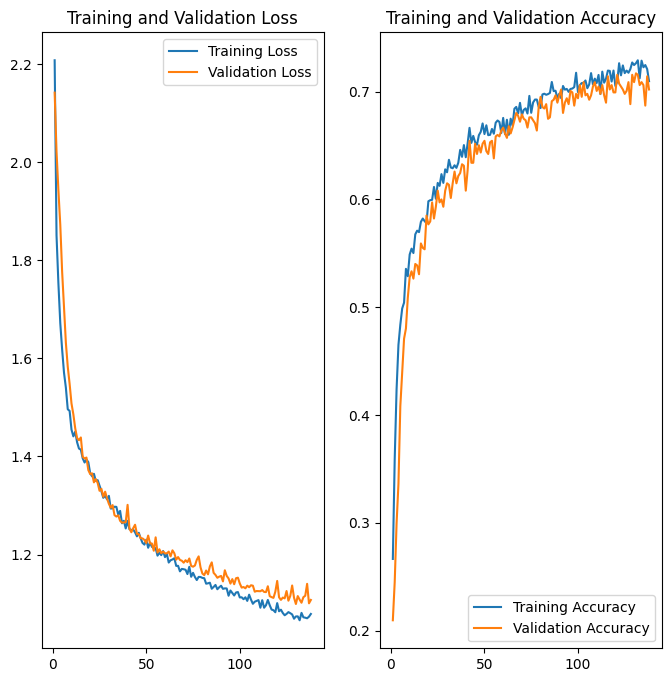

In [ ]:
# Visualization of the learning curves
acc = np.concatenate((history.history['accuracy'], history2.history['accuracy']), axis=0)
val_acc = np.concatenate((history.history['val_accuracy'], history2.history['val_accuracy']), axis=0)

loss = np.concatenate((history.history['loss'], history2.history['loss']), axis=0)
val_loss = np.concatenate((history.history['val_loss'], history2.history['val_loss']), axis=0)

num_epochs = len(history.epoch) + len(history2.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = net.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 280ms/step - loss: 1.0992 - accuracy: 0.7088
Test loss: 1.0991992950439453
Test accuracy: 0.7088435292243958


### Validation using prediction method

In [ ]:
# Inference
yc_pred = net.predict(val_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

6/6 [==============================] - 2s 311ms/step
Prediction shape (probability distribution): (735, 5)


In [ ]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)

In [ ]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)

In [ ]:
y_test = np.argmax(yc_test, axis=1)

In [ ]:
accuracy_score(y_test, y_pred)

0.708843537414966

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       127
           1       0.67      0.85      0.75       180
           2       0.63      0.62      0.62       128
           3       0.82      0.82      0.82       140
           4       0.69      0.55      0.61       160

    accuracy                           0.71       735
   macro avg       0.71      0.70      0.70       735
weighted avg       0.71      0.71      0.71       735



17% i guess the right class if i consider the class 0

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

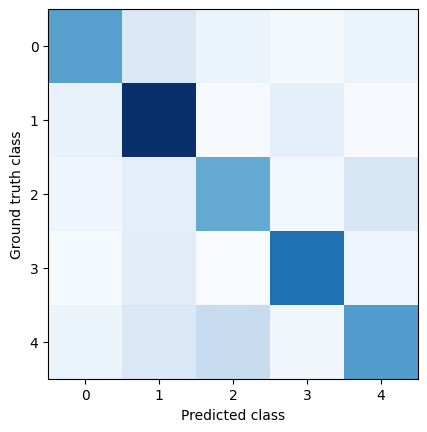

In [ ]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

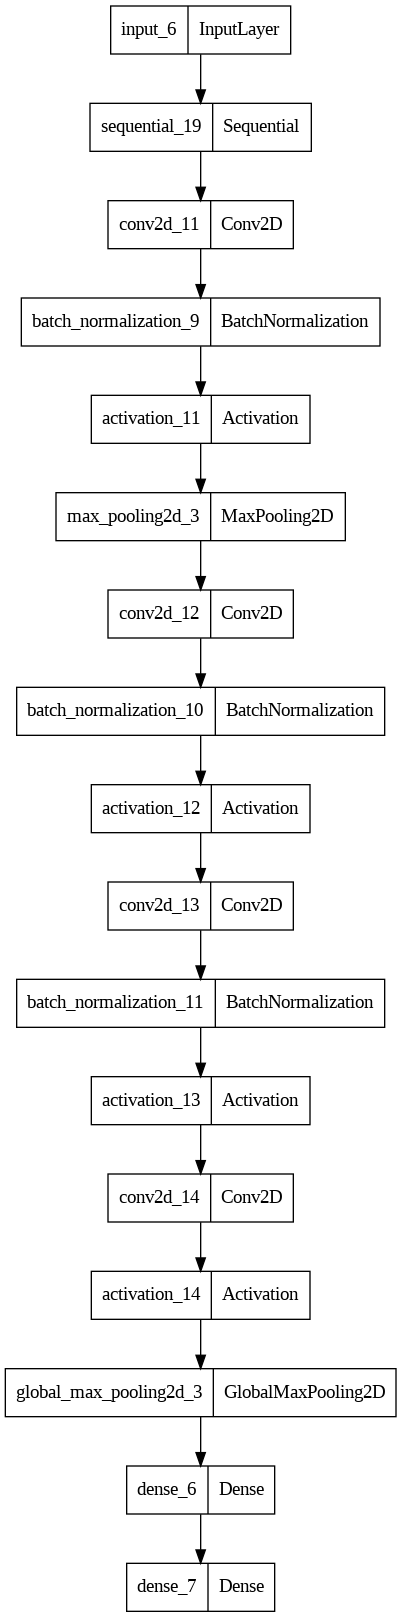

In [ ]:
keras.utils.plot_model(net)